In [1]:
%pylab inline

from pycuda.compiler import SourceModule
import theano
import theano.tensor as T
import theano.misc.pycuda_init
import theano.sandbox.cuda as cuda

Populating the interactive namespace from numpy and matplotlib


C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\theano\configdefaults.py:1695: UserWarning: Theano does not recognise this flag: Value
  warnings.warn('Theano does not recognise this flag: {0}'.format(key))
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/scnerd/AppData/Local/Theano/compiledir_Windows-10-10.0.14931-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.4.5-64/tmpd5nmwlpb/m91973e5c136ea49268a916ff971b7377.lib and object C:/Users/scnerd/AppData/Local/Theano/compiledir_Windows-10-10.0.14931-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-3.4.5-64/tmpd5nmwlpb/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5105)
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\theano\sandbox\cuda\__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


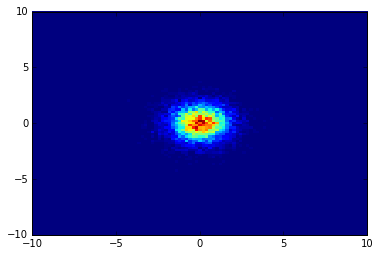

(100, 100)


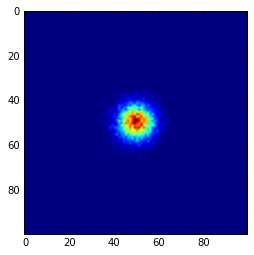

[(0.44489268246032487, -1.0238195104218921, 52, 44), (-0.63445406026407014, -0.59525222440089454, 46, 47), (-0.05667039785631206, 0.22720849672381557, 49, 51), (0.55740700726280656, -0.29489873580502451, 52, 48), (-0.76405767744696362, -2.1055720339142048, 46, 39), (1.8147122467578274, 1.193197598562161, 59, 55), (-2.8549248025287883, -0.82696396886776924, 35, 45), (-0.23544737835653579, 0.35264668938639226, 48, 51), (-0.81641094938033099, 0.47449542971188408, 45, 52), (0.63448804587321539, -0.38481666163722011, 53, 48)]


In [2]:
class PyCUDAHist2D(theano.Op):
    __props__ = ('n', 'xres', 'yres', 'xmin', 'xptp', 'ymin', 'yptp', 'num_chans', 'length')

    def __init__(self, n, width, height, xmin=-1.0, xmax=1.0, ymin=-1.0, ymax=1.0, num_chans=4, length=16):
        self.n = n
        self.xres = width
        self.yres = height
        self.xmin = xmin
        self.xptp = xmax - xmin
        self.ymin = ymin
        self.yptp = ymax - ymin
        self.num_chans = num_chans
        self.length = length

    def make_node(self, x, y, w):
        x = cuda.basic_ops.gpu_contiguous(cuda.basic_ops.as_cuda_ndarray_variable(x))
        y = cuda.basic_ops.gpu_contiguous(cuda.basic_ops.as_cuda_ndarray_variable(y))
        w = cuda.basic_ops.gpu_contiguous(cuda.basic_ops.as_cuda_ndarray_variable(w))
        out_t = cuda.CudaNdarrayType((False, False, False, False), dtype='float32')()
        out_x = cuda.CudaNdarrayType((False,))()
        out_y = cuda.CudaNdarrayType((False,))()
        assert x.dtype == 'float32'
        assert y.dtype == 'float32'
        assert w.dtype == 'float32'
        return theano.Apply(self, [x, y, w], [out_t, out_x, out_y])

    # Based on
    #https://devblogs.nvidia.com/parallelforall/gpu-pro-tip-fast-histograms-using-shared-atomics-maxwell/
    def make_thunk(self, node, storage_map, _, _2):

        # Creates a histogram in BLOCKS_X pieces, which then need to be added together
        code = '''
        __global__ void histogram2d(const float *in_x, const float *in_y, const float *in_w, float *out, float *out_binx, float *out_biny) {{
            int start = (blockIdx.x * blockDim.x + threadIdx.x) * {length};

            float *block_out = &out[{xres} * {yres} * {num_chans} * blockIdx.x];
            //float *block_out = out;

            for(int i = 0; i < {length}; i++) {{
                float x = in_x[start + i];
                float y = in_y[start + i];
                int w_idx = (start + i) * {num_chans};

                int xbin = (int) (((x - {xmin}) / {xptp}) * {xres});
                int ybin = (int) (((y - {ymin}) / {yptp}) * {yres});

                if (0 <= xbin && xbin < {xres} && 0 <= ybin && ybin < {yres}) {{
                    out_binx[start + i] = (float)xbin;
                    out_biny[start + i] = (float)ybin;
                    for(int c = 0; c < {num_chans}; c++) {{
                        atomicAdd(&block_out[(ybin * {xres} + xbin) * {num_chans} + c], in_w[w_idx + c]);
                    }}
                }}
            }}
        }}
        '''.format(**{p: eval("self.{}".format(p), {'self': self}) for p in self.__props__})
        mod = SourceModule(code)
        cuda_hist = mod.get_function('histogram2d')

        inputs = [storage_map[v] for v in node.inputs]
        outputs = [storage_map[v] for v in node.outputs]

        _x, _y, _w = inputs
        (_out,_outx,_outy) = outputs

        def run_hist():
            x = _x[0]
            y = _y[0]
            w = _w[0]
            n = x.size
            xres = self.xres
            yres = self.yres
            num_chans = self.num_chans
            length = self.length
            num_blocks = 2
            threads_per_block = int(n / length / num_blocks)
            if _out[0] is None or _out[0].shape != (num_blocks, yres, xres, num_chans):
                _out[0] = cuda.CudaNdarray.zeros((num_blocks, yres, xres, num_chans))
                _outx[0] = cuda.CudaNdarray.zeros((n,))
                _outy[0] = cuda.CudaNdarray.zeros((n,))
            cuda_hist(x, y, w, _out[0], _outx[0], _outy[0], block=(threads_per_block,1,1), grid=(num_blocks,1))

        return run_hist#, zeros((num_blocks, yres, xres, num_chans), 'float32')
    
x = np.random.randn(10000)
y = np.random.randn(10000)
w = np.ones(10000)
plt.figure()
plt.hist2d(x, y, bins=[np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)])
plt.show(block=False)

_x = T.fvector('x')
_y = T.fvector('y')
_w = T.fvector('w')
hister = PyCUDAHist2D(10000, 100, 100, num_chans=1, xmin=-10, xmax=10, ymin=-10, ymax=10)
f = theano.function([_x, _y, _w], hister(_x, _y, _w), allow_input_downcast=True)

hist, x_assgn, y_assgn = f(x, y, w)
hist = np.array(hist).sum(axis=0).sum(axis=-1)
x_assgn = np.cast['int'](np.array(x_assgn))
y_assgn = np.cast['int'](np.array(y_assgn))
print(hist.shape)
plt.figure()
plt.imshow(hist)
plt.show(block=False)
print(list(zip(x, y, x_assgn, y_assgn))[:10])

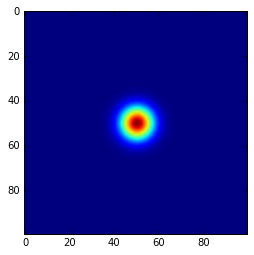

C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:51: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu



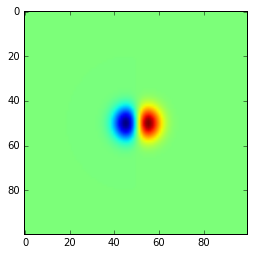

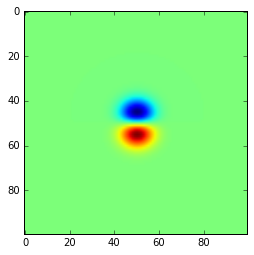

In [47]:
class PyCUDASlopeKernel(theano.Op):
    __props__ = ('height', 'width')

    def __init__(self, height, width):
        self.height = height
        self.width = width

    def make_node(self, h):
        h = cuda.basic_ops.gpu_contiguous(cuda.basic_ops.as_cuda_ndarray_variable(h))
        out_dx = cuda.CudaNdarrayType((False, False), dtype='float32')()
        out_dy = cuda.CudaNdarrayType((False, False), dtype='float32')()
        assert h.dtype == 'float32'
        return theano.Apply(self, [h], [out_dx, out_dy])

    # Based on
    #https://devblogs.nvidia.com/parallelforall/gpu-pro-tip-fast-histograms-using-shared-atomics-maxwell/
    def make_thunk(self, node, storage_map, _, _2):

        # Creates a histogram in BLOCKS_X pieces, which then need to be added together
        code = '''
        __device__ __inline__ float val_at(const float *hist, int x, int y) {{
            x = min(max(x, 0), {width} - 1);
            y = min(max(y, 0), {height} - 1);
            return hist[y * {width} + x];
        }}
        
        __device__ __inline__ float clipper(float mid, const float *hist, int x, int y) {{
            // return min(mid, val_at(hist, x, y));
            return val_at(hist, x, y);
        }}

        __global__ void slope_kernel(const float *histogram, float *dx, float *dy) {{
            int x = (blockIdx.x * blockDim.x + threadIdx.x);
            int y = (blockIdx.y * blockDim.y + threadIdx.y);
            if (x < {width} && y < {height}) {{
                float v4 = val_at(histogram, x, y);
                float d0 = v4 - clipper(v4, histogram, x-1, y-1);
                float d1 = v4 - clipper(v4, histogram, x,   y-1);
                float d2 = v4 - clipper(v4, histogram, x+1, y-1);
                float d3 = v4 - clipper(v4, histogram, x-1, y  );
                float d5 = v4 - clipper(v4, histogram, x+1, y  );
                float d6 = v4 - clipper(v4, histogram, x-1, y+1);
                float d7 = v4 - clipper(v4, histogram, x,   y+1);
                float d8 = v4 - clipper(v4, histogram, x+1, y+1);

                dx[y * {width} + x] = {root2} * (d2 + d8 - d0 - d6) + d5 - d3;
                dy[y * {width} + x] = {root2} * (d6 + d8 - d0 - d2) + d7 - d1;
            }}
        }}
        '''.format(height=self.height, width=self.width, root2=np.sqrt(2))
        mod = SourceModule(code)
        cuda_kern = mod.get_function('slope_kernel')

        inputs = [storage_map[v] for v in node.inputs]
        outputs = [storage_map[v] for v in node.outputs]

        (_h,) = inputs
        (_outx,_outy) = outputs

        threads = 16
        num_blocks_h = int(np.ceil(self.height / threads))
        num_blocks_w = int(np.ceil(self.width / threads))
        def run_kern():
            if _outx[0] is None or _outx[0].shape != (self.height, self.width):
                _outx[0] = cuda.CudaNdarray.zeros((self.height, self.width))
                _outy[0] = cuda.CudaNdarray.zeros((self.height, self.width))
            cuda_kern(_h[0], _outx[0], _outy[0], block=(threads,threads,1), grid=(num_blocks_w,num_blocks_h))

        return run_kern
    
x = np.arange(100)
y = np.arange(100)
x, y = np.meshgrid(x, y)
g = np.exp(-( (x - 50)**2 / 50 + (y - 50)**2 / 50 ))
plt.figure()
plt.imshow(g)
plt.show(block=False)

_hist = T.fmatrix('hist')
sloper = PyCUDASlopeKernel(100, 100)
f = theano.function([_hist], sloper(_hist), allow_input_downcast=True)

dx, dy = f(g)
plt.figure()
plt.imshow(dx)
plt.show(block=False)
plt.figure()
plt.imshow(dy)
plt.show(block=False)

In [79]:
cast = np.cast['float32']

height = 480
width = 640
n = 10000000
rebound = cast(0.9)
time_step = cast(0.0001)
time_step = theano.shared(time_step)
hist_length = 2**16
gravity = cast((0, 1000))

sizes = np.ones(n)
_reset_posx = lambda: np.clip(np.hstack([np.random.normal(loc=0.1, scale=0.01, size=n/2), np.random.normal(loc=0.7, scale=0.1, size=n/2)]), 0, 1)
_reset_posy = lambda: np.clip(np.random.normal(loc=0.5, scale=0.1, size=n), 0, 1)
_reset_velx = lambda: np.hstack([np.random.normal(loc=-10, scale=0.01, size=n/2), np.random.normal(loc=-10, scale=0.01, size=n/2)])
_reset_vely = lambda: np.random.normal(loc=0, scale=0.01, size=n)
cuda_cast = lambda v: cuda.CudaNdarray(cast(v))

_posx = theano.shared(cuda_cast(_reset_posx()), name='posx')
_posy = theano.shared(cuda_cast(_reset_posy()), name='posy')
_velx = theano.shared(cuda_cast(_reset_velx()), name='velx')
_vely = theano.shared(cuda_cast(_reset_vely()), name='vely')
_size = theano.shared(cuda_cast(sizes), name='sizes')

_mass = _size ** 2 # we're working in 2D, so this is close enough

hister = PyCUDAHist2D(n, width, height, num_chans=1, xmin=0, xmax=1, ymin=0, ymax=1, length=hist_length)
sloper = PyCUDASlopeKernel(height, width)

hist, x_assgns, y_assgns = hister(_posx, _posy, _size)
x_assgns = T.cast(x_assgns, 'int32')
y_assgns = T.cast(y_assgns, 'int32')

dx, dy = sloper(hist**2)

dx = dx[y_assgns, x_assgns]
dy = dy[y_assgns, x_assgns]
out_velx = _velx + time_step * dx / _mass + time_step * gravity[0]
out_vely = _vely + time_step * dy / _mass + time_step * gravity[1]
out_posx = _posx + time_step * _velx
out_posy = _posy + time_step * _vely

off_left = T.lt(out_posx, 0)
off_right = T.gt(out_posx, 1)
off_top = T.lt(out_posy, 0)
off_bott = T.gt(out_posy, 1)
rebound_x = off_left | off_right
rebound_y = off_top | off_bott

out_velx = T.switch(rebound_x, cast(rebound) * -out_velx, out_velx)
out_vely = T.switch(rebound_y, cast(rebound) * -out_vely, out_vely)
out_posx = T.switch(off_right, cast(1)-out_posx, T.switch(off_left, -out_posx, out_posx))
out_posy = T.switch(off_bott, cast(1)-out_posy, T.switch(off_top, -out_posy, out_posy))

step = theano.function([], [],
                       updates=[(_posx, out_posx), (_posy, out_posy),
                                (_velx, out_velx), (_vely, out_vely)],
                       allow_input_downcast=True)
render = theano.function([], [T.log(1+hist.sum(axis=0).sum(axis=-1))], allow_input_downcast=True)
reset = theano.function([], [], updates=[
        (_posx, cuda_cast(_reset_posx())),
        (_posy, cuda_cast(_reset_posy())),
        (_velx, cuda_cast(_reset_velx())),
        (_vely, cuda_cast(_reset_vely())),
    ])

C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
lump = np.random.choice(np.arange(n), 0.1 * n, replace=False)

reset()

from tqdm import tqdm
print_every_iter = False
renders = []
for i in tqdm(range(10000)):
#     if i > 0:
#         if not i % 100:
#             time_step.set_value(cast(0.001))
#         elif not i % 10:
#             time_step.set_value(cast(0.0001))
    step()
    r, = render()
    renders.append(np.array(r))

C:\Users\scnerd\Anaconda3\envs\Anaconda34\lib\site-packages\ipykernel\__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
  6%|█████████████▎                                                                                                                                                                                                                  | 594/10000 [07:45<2:09:41,  1.21it/s]

In [31]:
renders = [np.array(r[0]).sum(axis=0).sum(axis=-1) for r in __renders]

In [ ]:
for i, rendered in enumerate(tqdm(renders)):
    plt.imsave('data/wave_render_5/frame_%d.png' % i, rendered, cmap=plt.cm.inferno)